# Random Forest

### Pre-Processing

In [1]:
import os
import pandas as pd
import numpy as np

# Define the base directory
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, 'Hourly Energy Consumption')

# Define utilities with file names
utilities = {
    'AEP': 'AEP_hourly.csv',
    'COMED': 'COMED_hourly.csv',
    'DAYTON': 'DAYTON_hourly.csv',
    'DEOK': 'DEOK_hourly.csv',
    'DOM': 'DOM_hourly.csv',
    'DUQ': 'DUQ_hourly.csv',
    'EKPC': 'EKPC_hourly.csv',
    'FE': 'FE_hourly.csv',
    'NI': 'Ni_hourly.csv',
    'PJMW': 'PJMW_hourly.csv'
}

# Function to remove outliers
def remove_outliers(series, threshold=3):
    mean = series.mean()
    std = series.std()
    return series[(series > mean - threshold * std) & (series < mean + threshold * std)]

# Function to handle duplicate timestamps
def handle_duplicates(df, mw_col):
    # Group by index and aggregate using mean
    df = df.groupby(df.index).mean()
    return df

# Preprocess function that loads data, handles outliers, duplicates, and adds time-based features
def preprocess_data(file_path, mw_col):
    df = pd.read_csv(file_path)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

    # Handle duplicates
    df = handle_duplicates(df, mw_col=mw_col)

    # Remove outliers
    df[mw_col] = remove_outliers(df[mw_col])

    # Drop any remaining missing values
    df.dropna(inplace=True)

    # Add time-based features: hour, day_of_week, and month
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month

    return df

# Go over all utilities and preprocess the data
processed_data = {}
for utility, filename in utilities.items():
    file_path = os.path.join(base_dir, filename)
    df = preprocess_data(file_path, mw_col=f'{utility}_MW')
    if not df.empty:
        print(f"Preprocessed data for {utility}:")
    else:
        print(f"Skipping {utility} due to insufficient data.")
    processed_data[utility] = df

# Print data preprocessing results to confirm
for utility, df in processed_data.items():
    print(f"Preprocessed data for {utility}:")
    print(df.head())





Preprocessed data for AEP:
Preprocessed data for COMED:
Preprocessed data for DAYTON:
Preprocessed data for DEOK:
Preprocessed data for DOM:
Preprocessed data for DUQ:
Preprocessed data for EKPC:
Preprocessed data for FE:
Preprocessed data for NI:
Preprocessed data for PJMW:
Preprocessed data for AEP:
                      AEP_MW  hour  day_of_week  month
Datetime                                              
2004-10-01 01:00:00  12379.0     1            4     10
2004-10-01 02:00:00  11935.0     2            4     10
2004-10-01 03:00:00  11692.0     3            4     10
2004-10-01 04:00:00  11597.0     4            4     10
2004-10-01 05:00:00  11681.0     5            4     10
Preprocessed data for COMED:
                     COMED_MW  hour  day_of_week  month
Datetime                                               
2011-01-01 01:00:00    9631.0     1            5      1
2011-01-01 02:00:00    9273.0     2            5      1
2011-01-01 03:00:00    9011.0     3            5      1
201

AEP Evaluation Metrics (Original Model):
  - Root Mean Squared Error (RMSE): 1837.8031738669108
  - Normalized RMSE (nRMSE): 0.1342442055417758
  - Mean Absolute Percentage Error (MAPE): 10.58%


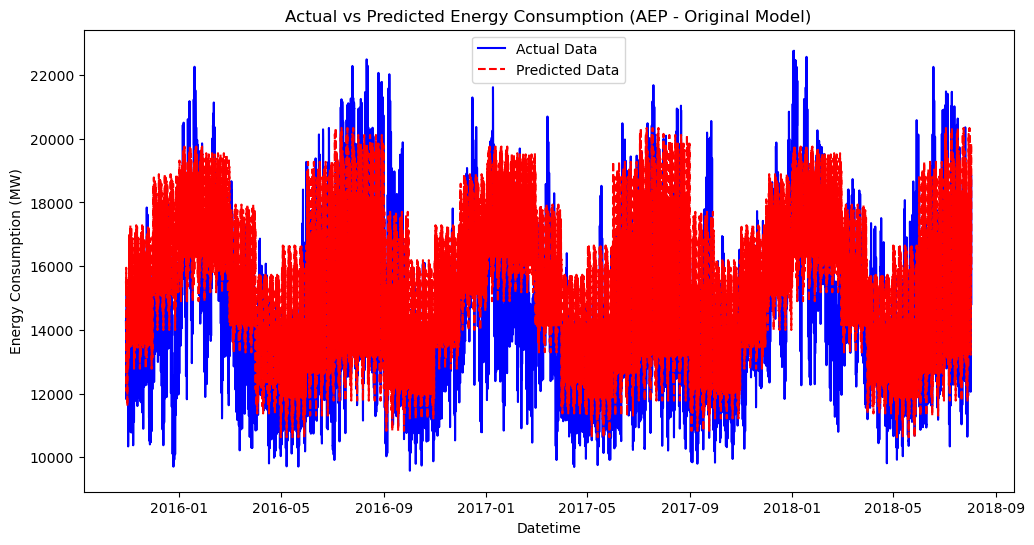

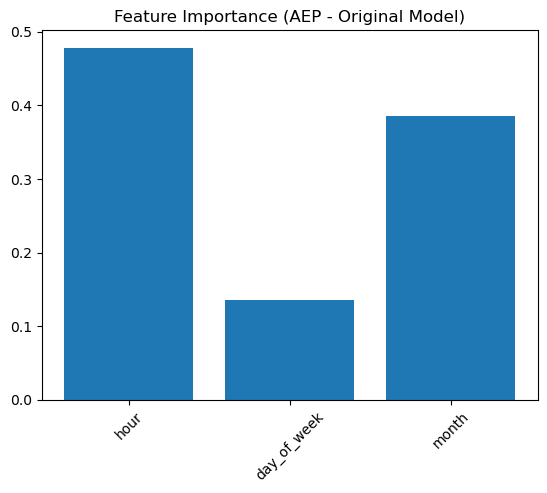

COMED Evaluation Metrics (Original Model):
  - Root Mean Squared Error (RMSE): 1249.908456695866
  - Normalized RMSE (nRMSE): 0.11265511101359767
  - Mean Absolute Percentage Error (MAPE): 8.18%


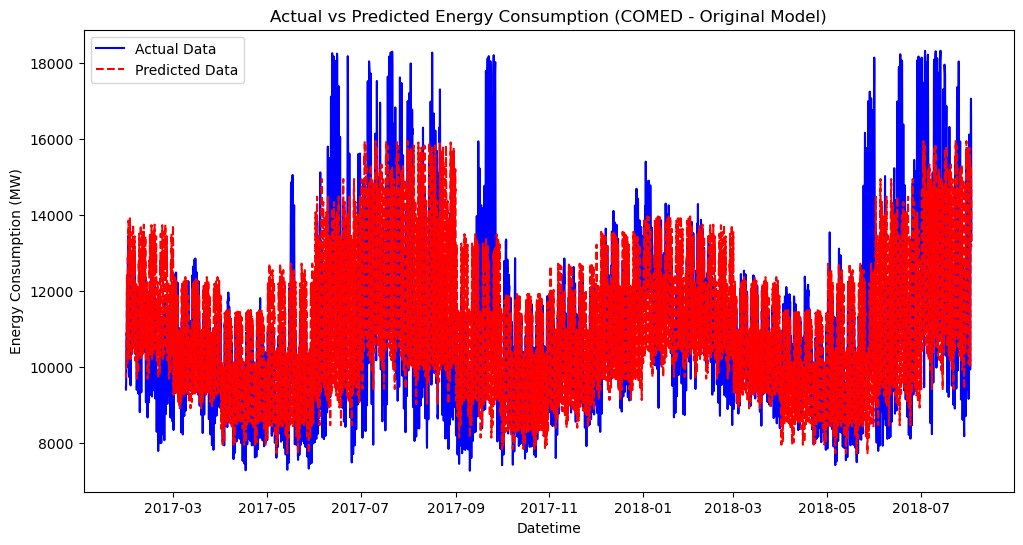

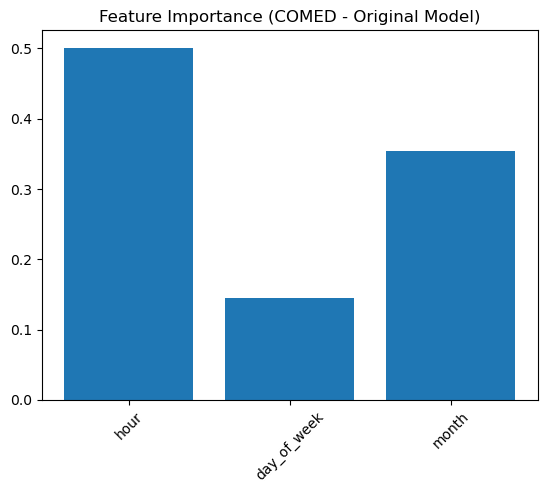

DAYTON Evaluation Metrics (Original Model):
  - Root Mean Squared Error (RMSE): 221.92551552680757
  - Normalized RMSE (nRMSE): 0.09925112501198907
  - Mean Absolute Percentage Error (MAPE): 8.82%


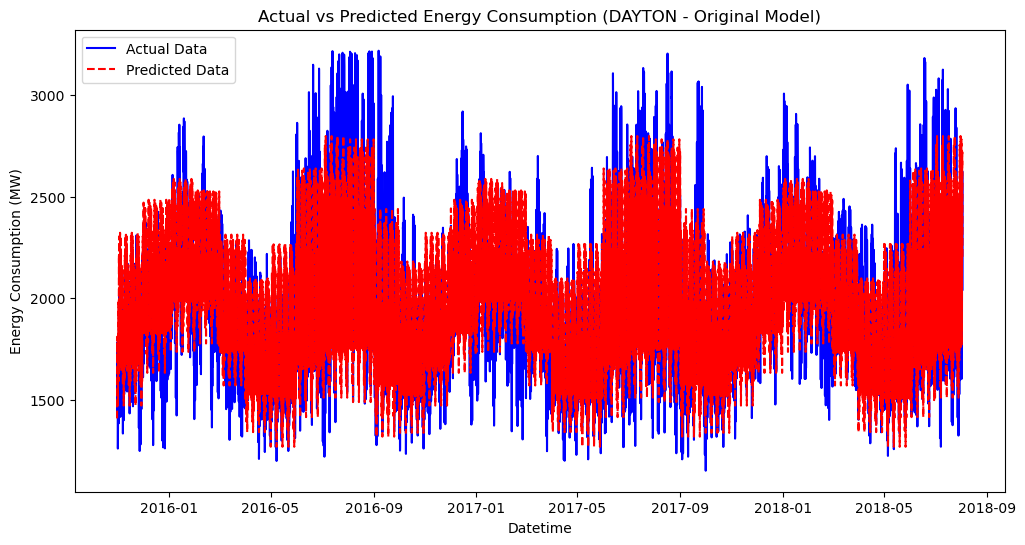

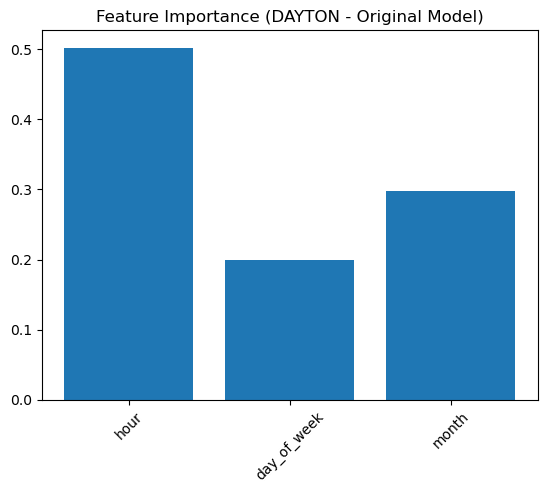

DEOK Evaluation Metrics (Original Model):
  - Root Mean Squared Error (RMSE): 355.40591185538744
  - Normalized RMSE (nRMSE): 0.10137076778533584
  - Mean Absolute Percentage Error (MAPE): 8.65%


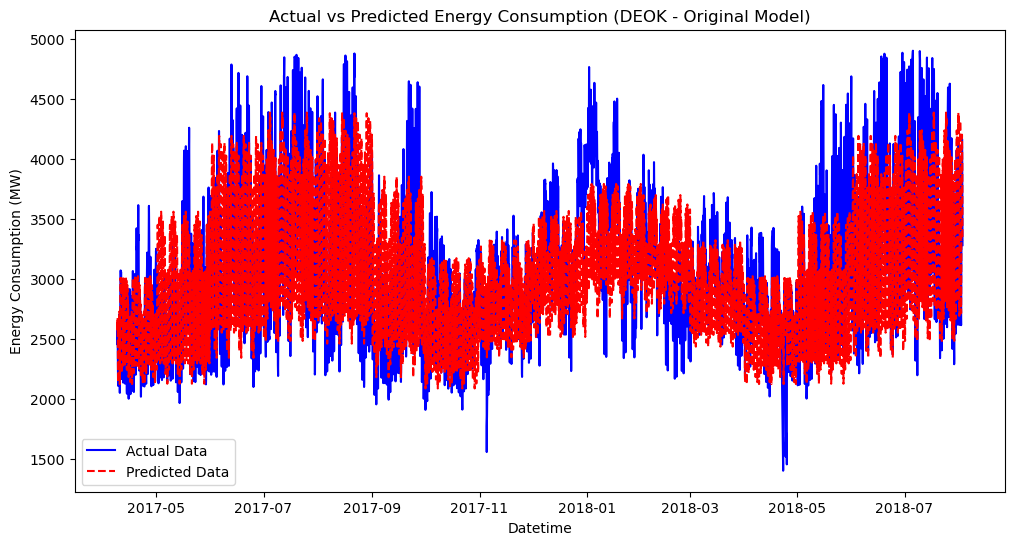

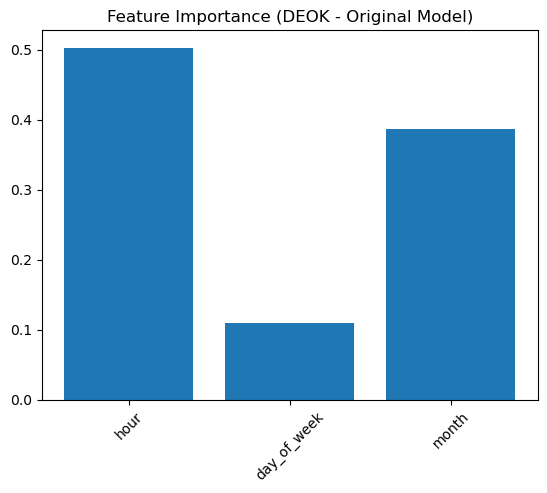

DOM Evaluation Metrics (Original Model):
  - Root Mean Squared Error (RMSE): 1547.3036094595752
  - Normalized RMSE (nRMSE): 0.12211377235100428
  - Mean Absolute Percentage Error (MAPE): 10.10%


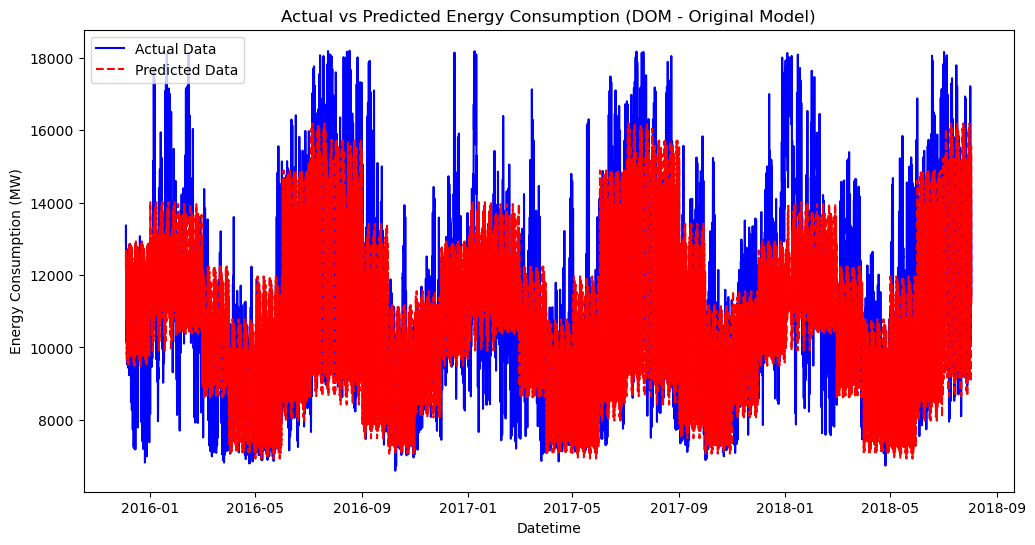

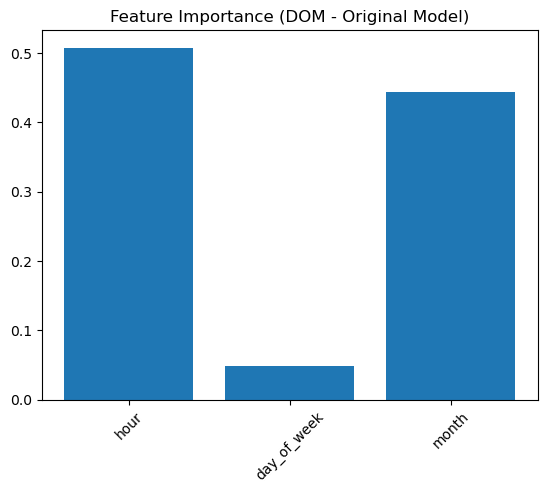

DUQ Evaluation Metrics (Original Model):
  - Root Mean Squared Error (RMSE): 196.42891724937869
  - Normalized RMSE (nRMSE): 0.12672833370927658
  - Mean Absolute Percentage Error (MAPE): 10.74%


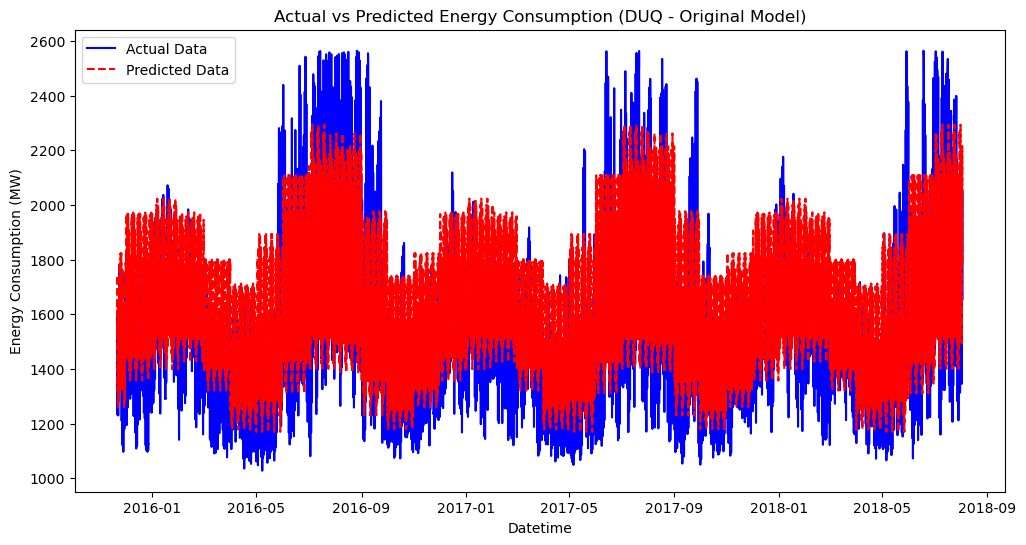

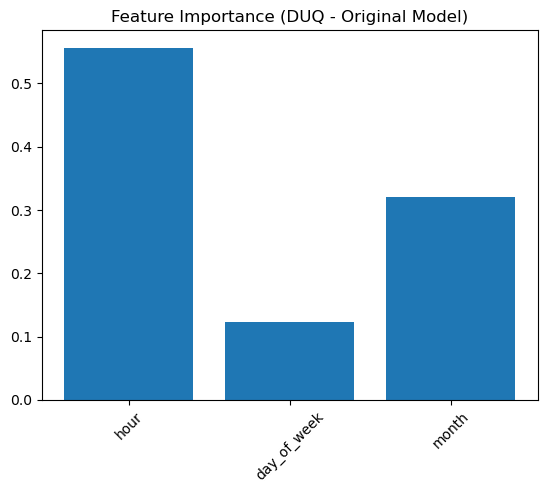

EKPC Evaluation Metrics (Original Model):
  - Root Mean Squared Error (RMSE): 254.68840716095355
  - Normalized RMSE (nRMSE): 0.12215271326664438
  - Mean Absolute Percentage Error (MAPE): 12.21%


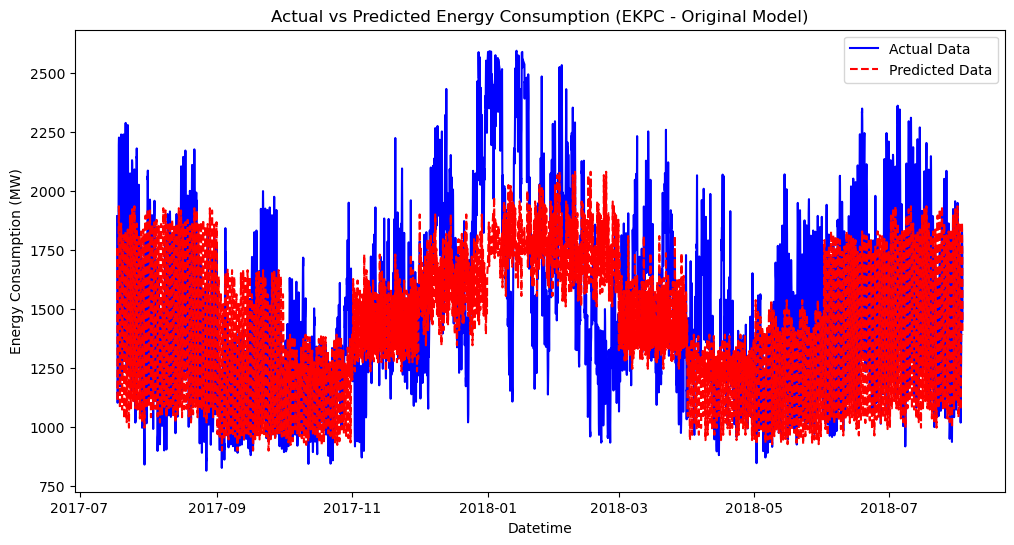

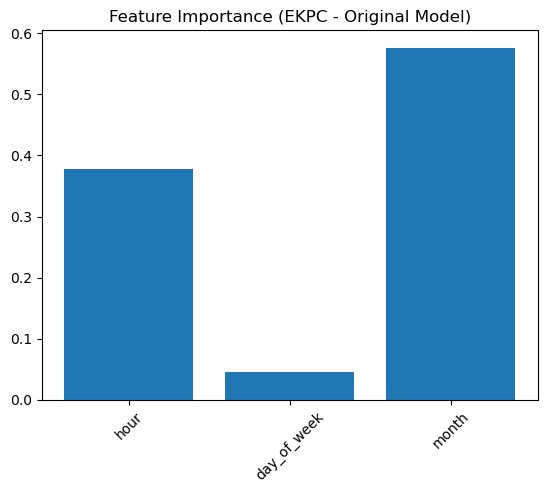

FE Evaluation Metrics (Original Model):
  - Root Mean Squared Error (RMSE): 713.6197654008705
  - Normalized RMSE (nRMSE): 0.10378414272845703
  - Mean Absolute Percentage Error (MAPE): 7.00%


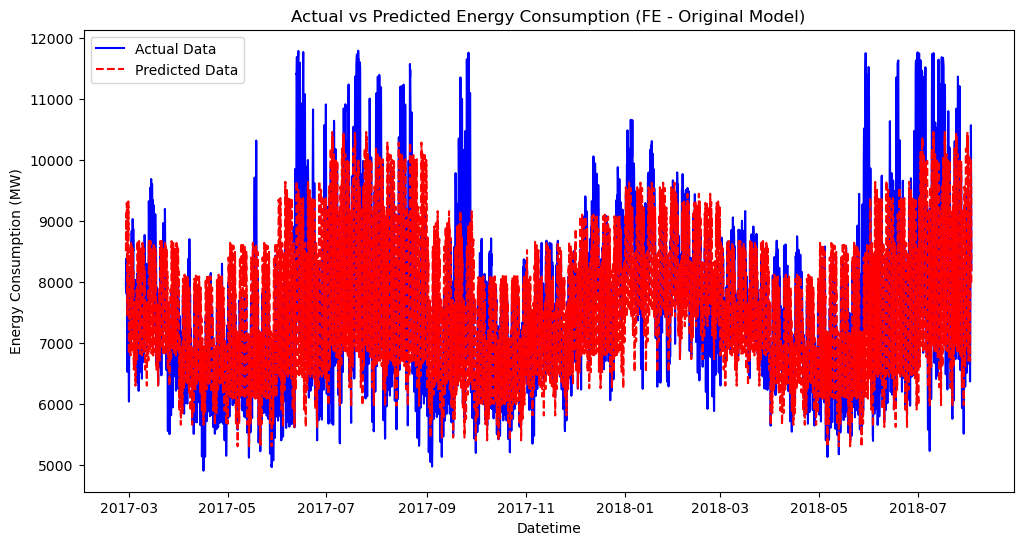

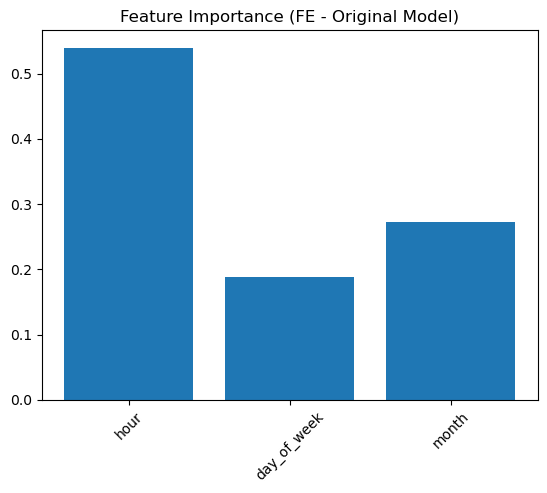

NI Evaluation Metrics (Original Model):
  - Root Mean Squared Error (RMSE): 1105.670835679359
  - Normalized RMSE (nRMSE): 0.09359780205530847
  - Mean Absolute Percentage Error (MAPE): 6.41%


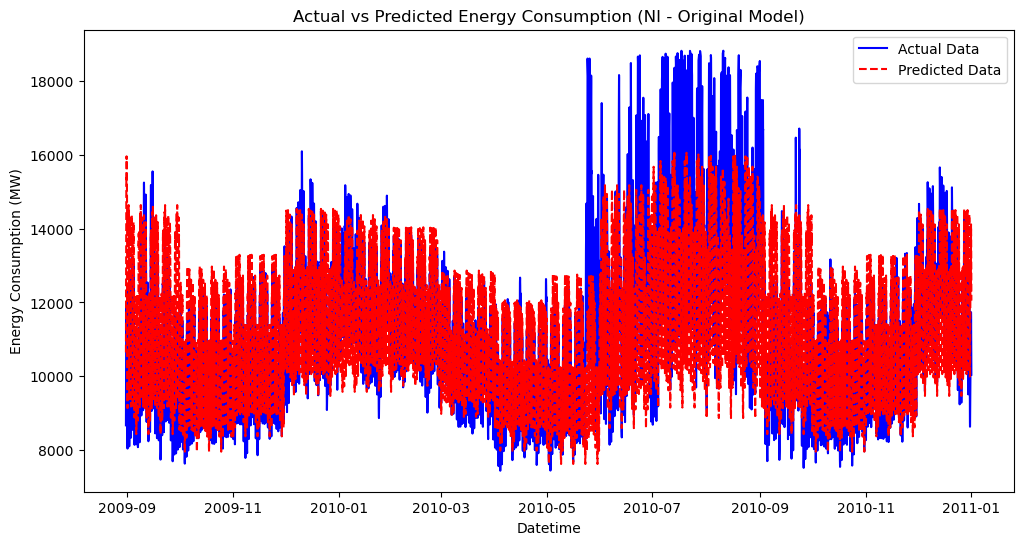

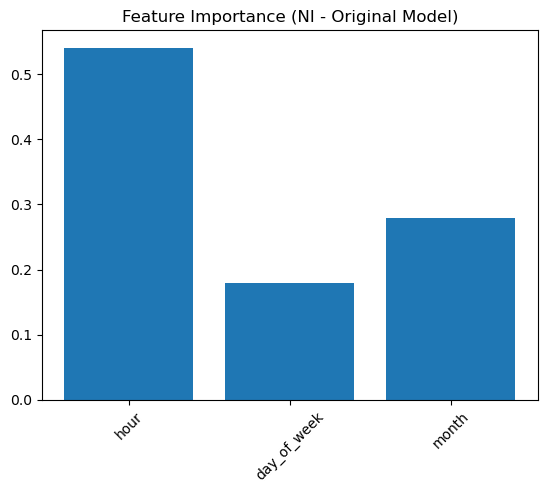

PJMW Evaluation Metrics (Original Model):
  - Root Mean Squared Error (RMSE): 605.7490804024382
  - Normalized RMSE (nRMSE): 0.10356455469352678
  - Mean Absolute Percentage Error (MAPE): 8.46%


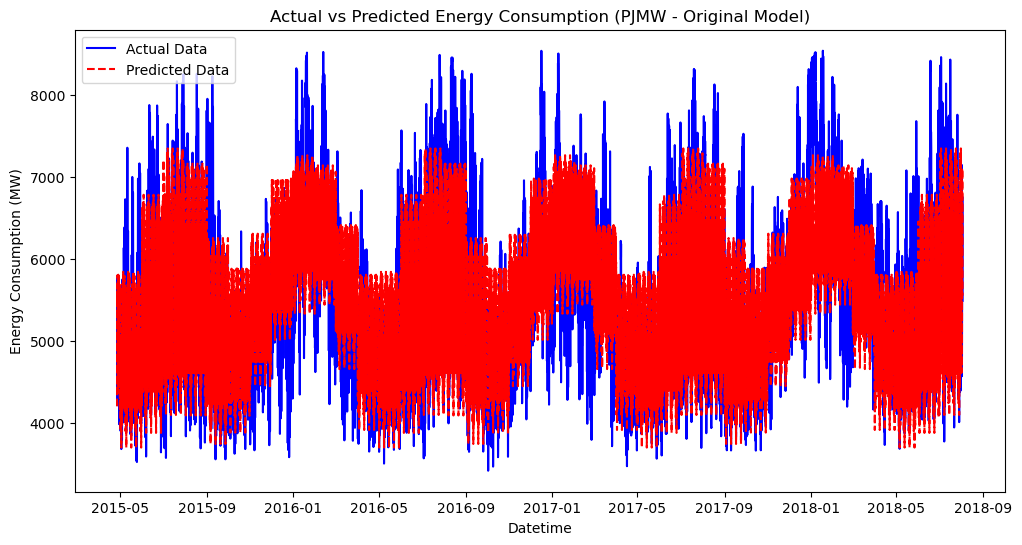

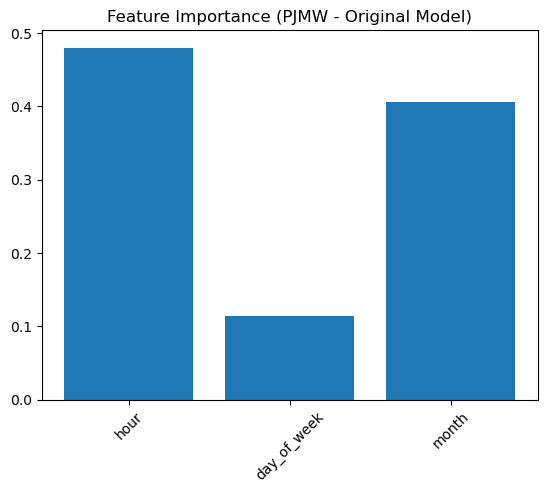

In [2]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
from sklearn.model_selection import train_test_split

# Testing and evaluating the original model (no hyperparameter tuning)
for utility, df in processed_data.items():
    target = f'{utility}_MW'
    features = ['hour', 'day_of_week', 'month'] 
    X = df[features]
    y = df[target]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) 

    # Training the model
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    # Evaluate the model using RMSE and normalized RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    value_range = y.max() - y.min()
    nrmse = rmse / value_range if value_range != 0 else np.nan

    # Evaluate the model using MAPE
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Print evaluation metrics
    print(f"{utility} Evaluation Metrics (Original Model):")
    print(f"  - Root Mean Squared Error (RMSE): {rmse}")
    print(f"  - Normalized RMSE (nRMSE): {nrmse}")
    print(f"  - Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

    # Visualize Results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
    plt.plot(y_test.index, y_pred, label='Predicted Data', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Energy Consumption ({utility} - Original Model)')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

    # Feature importance visualized
    importance = rf.feature_importances_
    plt.bar(features, importance)
    plt.title(f'Feature Importance ({utility} - Original Model)')
    plt.xticks(rotation=45)
    plt.show()



Metrics for AEP (Tuned Model):
  Root Mean Squared Error (RMSE): 1837.72
  Normalized RMSE (nRMSE): 13.95%
  Mean Absolute Percentage Error (MAPE): 10.58%


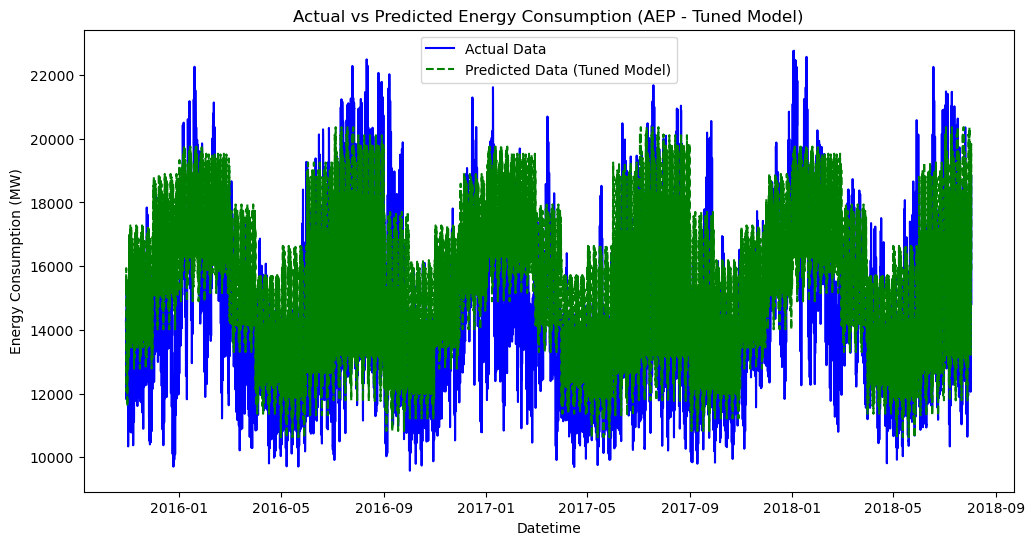

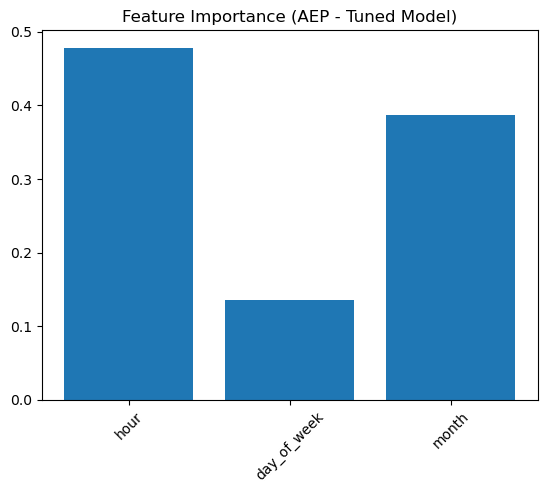

Best parameters for AEP from GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Metrics for COMED (Tuned Model):
  Root Mean Squared Error (RMSE): 1241.06
  Normalized RMSE (nRMSE): 11.21%
  Mean Absolute Percentage Error (MAPE): 8.17%


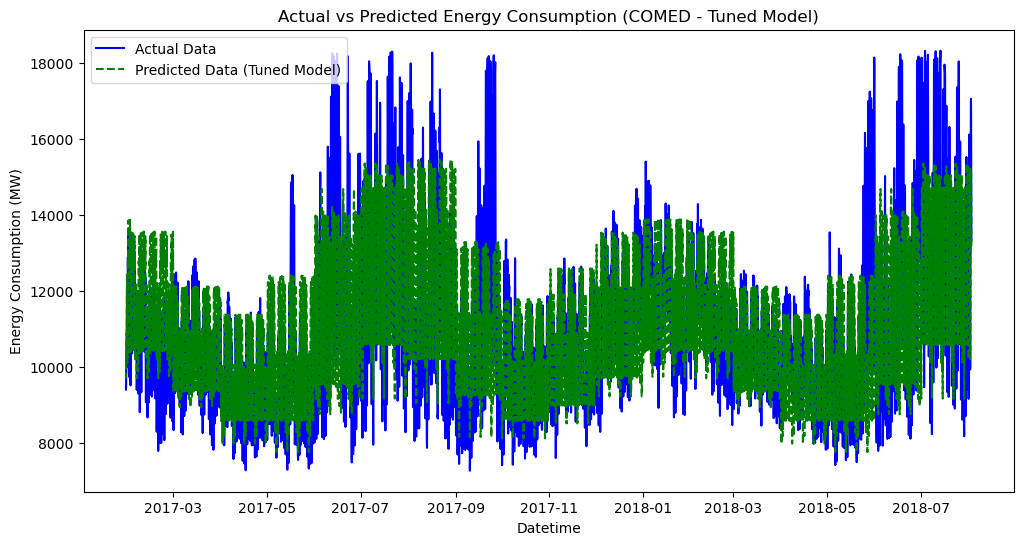

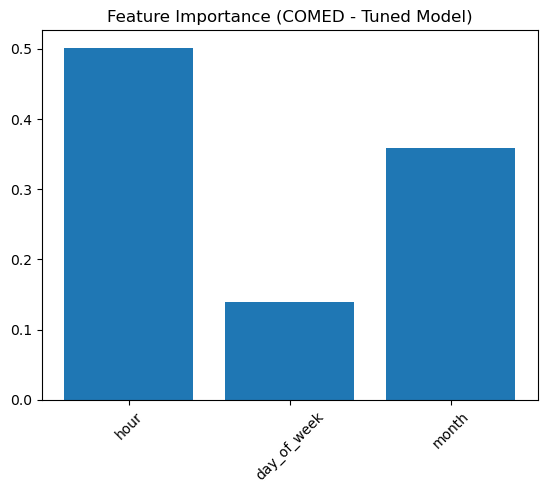

Best parameters for COMED from GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Metrics for DAYTON (Tuned Model):
  Root Mean Squared Error (RMSE): 221.91
  Normalized RMSE (nRMSE): 10.74%
  Mean Absolute Percentage Error (MAPE): 8.82%


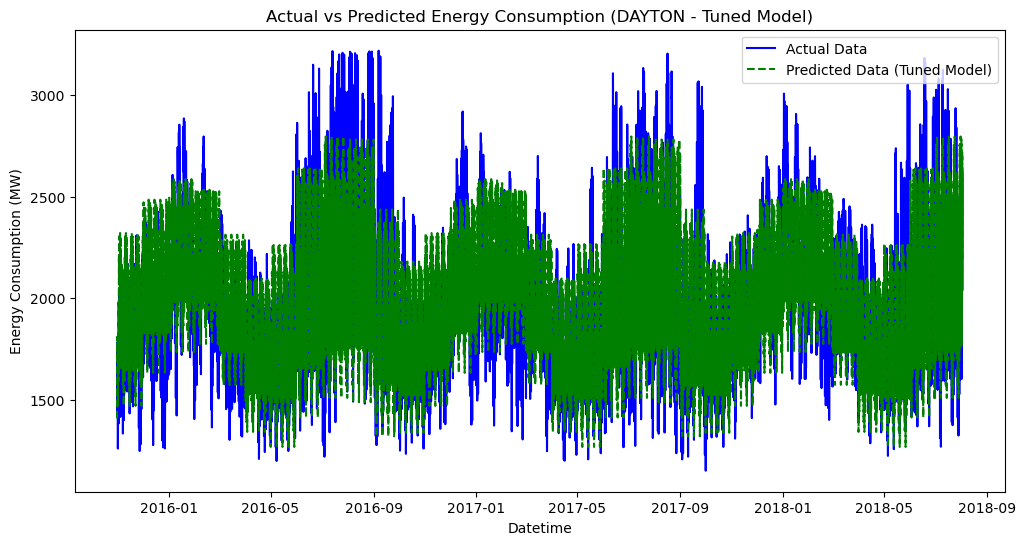

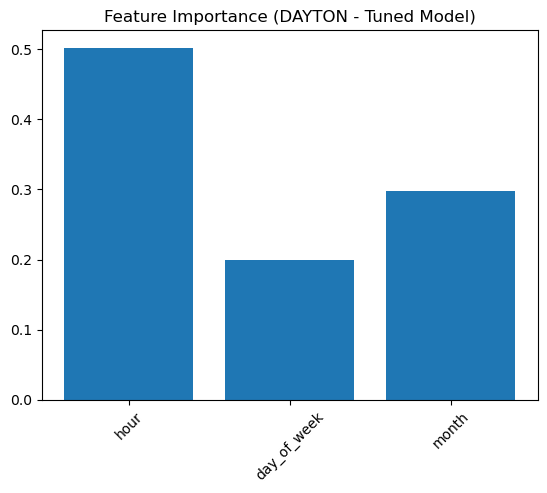

Best parameters for DAYTON from GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Metrics for DEOK (Tuned Model):
  Root Mean Squared Error (RMSE): 355.41
  Normalized RMSE (nRMSE): 10.14%
  Mean Absolute Percentage Error (MAPE): 8.65%


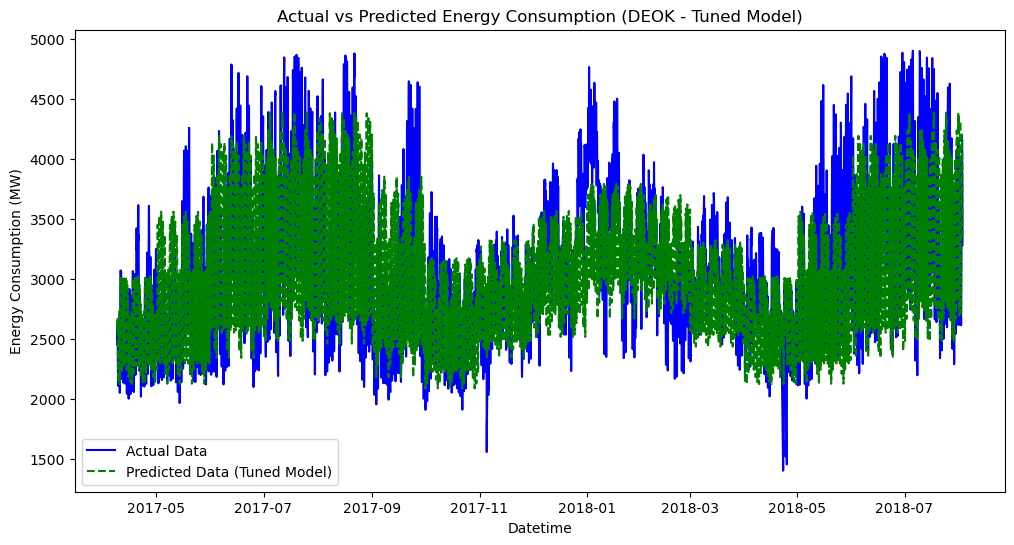

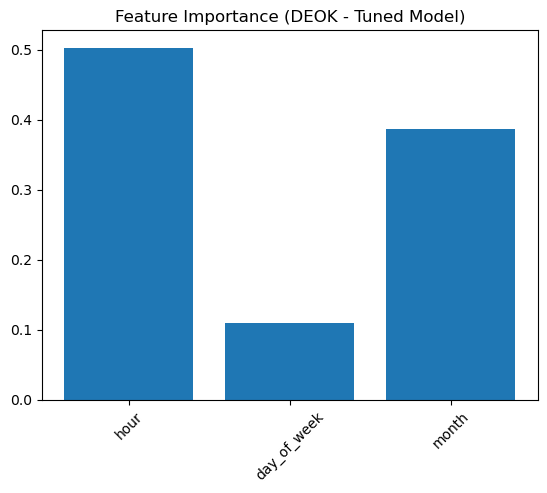

Best parameters for DEOK from GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Metrics for DOM (Tuned Model):
  Root Mean Squared Error (RMSE): 1547.31
  Normalized RMSE (nRMSE): 13.35%
  Mean Absolute Percentage Error (MAPE): 10.10%


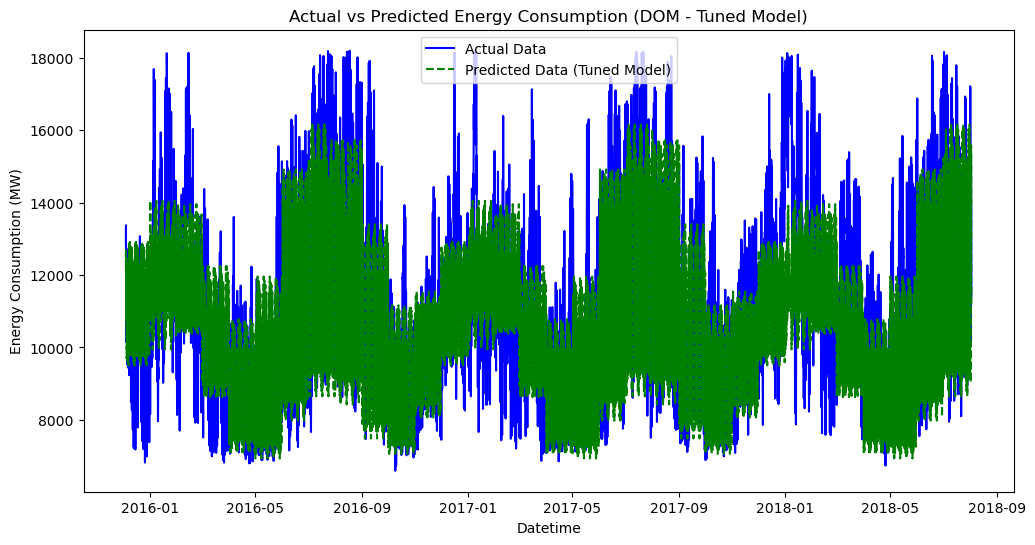

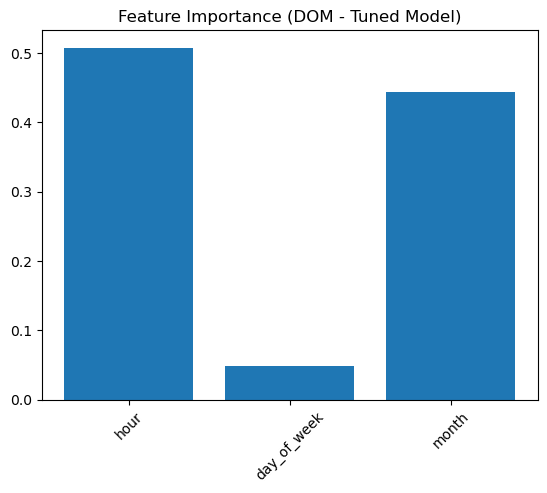

Best parameters for DOM from GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Metrics for DUQ (Tuned Model):
  Root Mean Squared Error (RMSE): 196.42
  Normalized RMSE (nRMSE): 12.79%
  Mean Absolute Percentage Error (MAPE): 10.74%


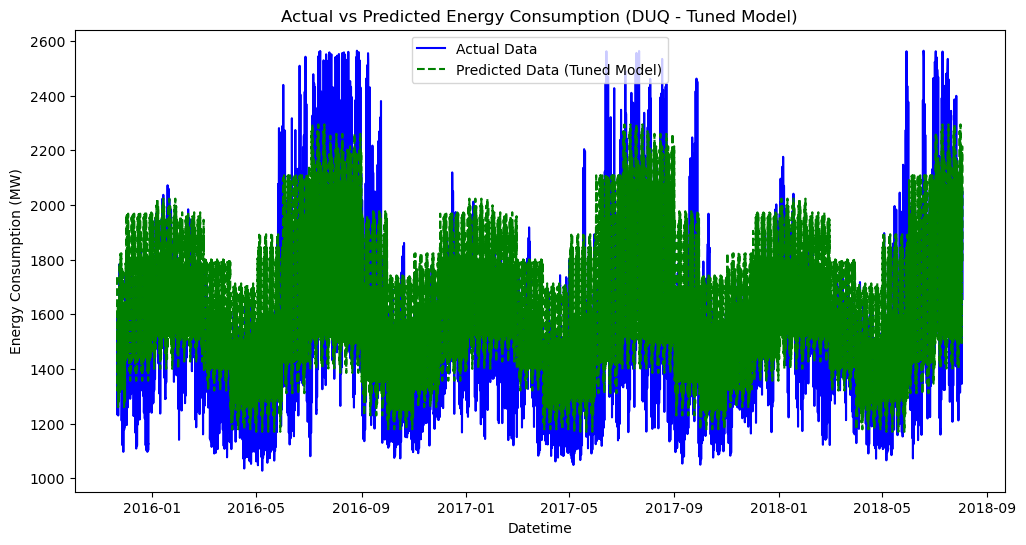

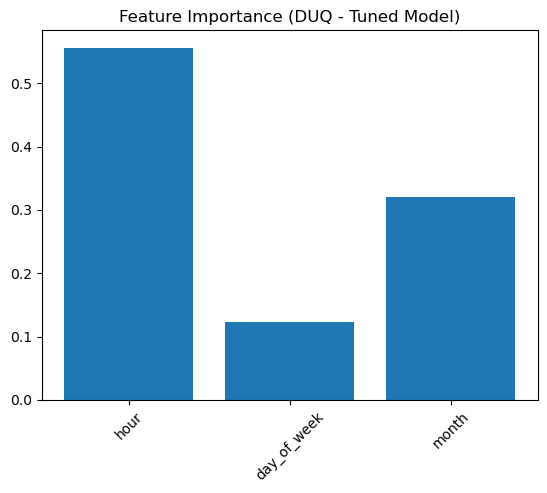

Best parameters for DUQ from GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Metrics for EKPC (Tuned Model):
  Root Mean Squared Error (RMSE): 254.56
  Normalized RMSE (nRMSE): 14.30%
  Mean Absolute Percentage Error (MAPE): 12.20%


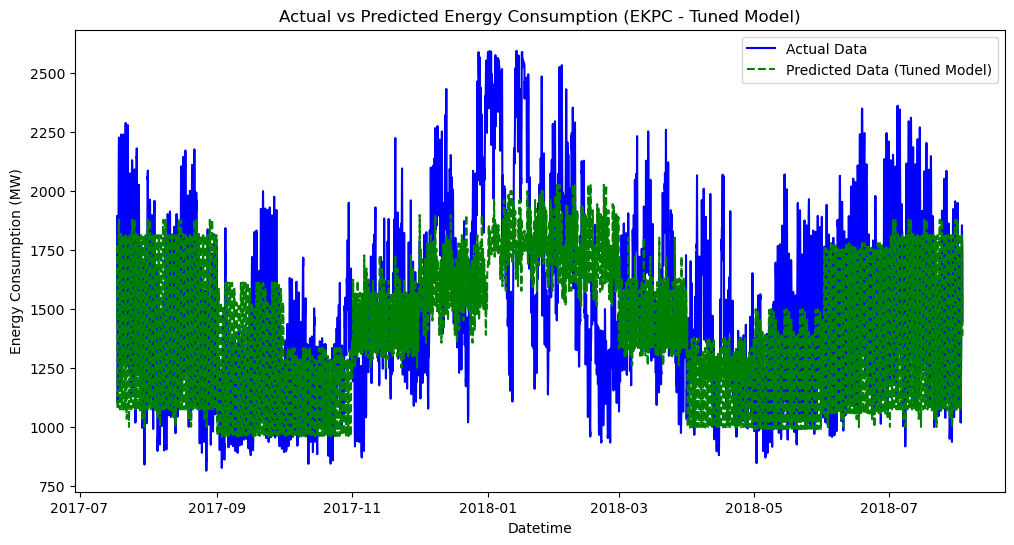

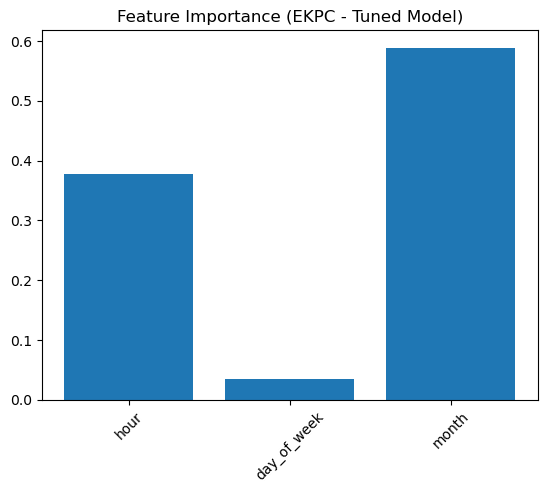

Best parameters for EKPC from GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}
Metrics for FE (Tuned Model):
  Root Mean Squared Error (RMSE): 713.62
  Normalized RMSE (nRMSE): 10.38%
  Mean Absolute Percentage Error (MAPE): 7.00%


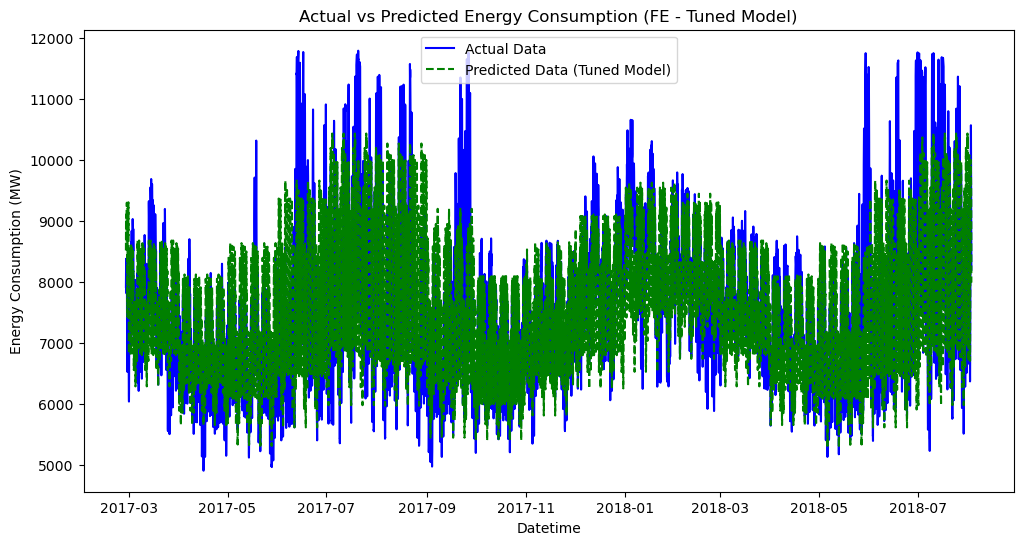

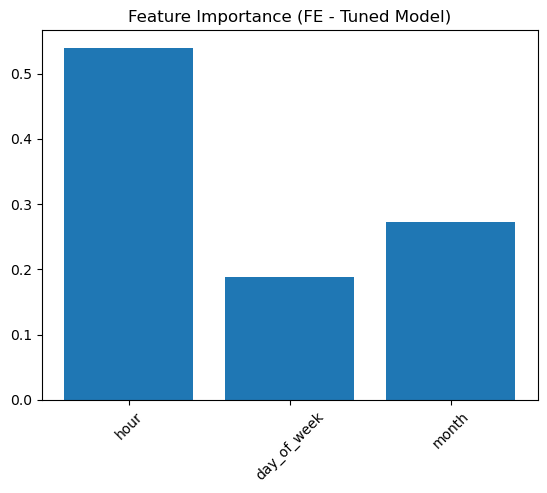

Best parameters for FE from GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Metrics for NI (Tuned Model):
  Root Mean Squared Error (RMSE): 1105.41
  Normalized RMSE (nRMSE): 9.72%
  Mean Absolute Percentage Error (MAPE): 6.41%


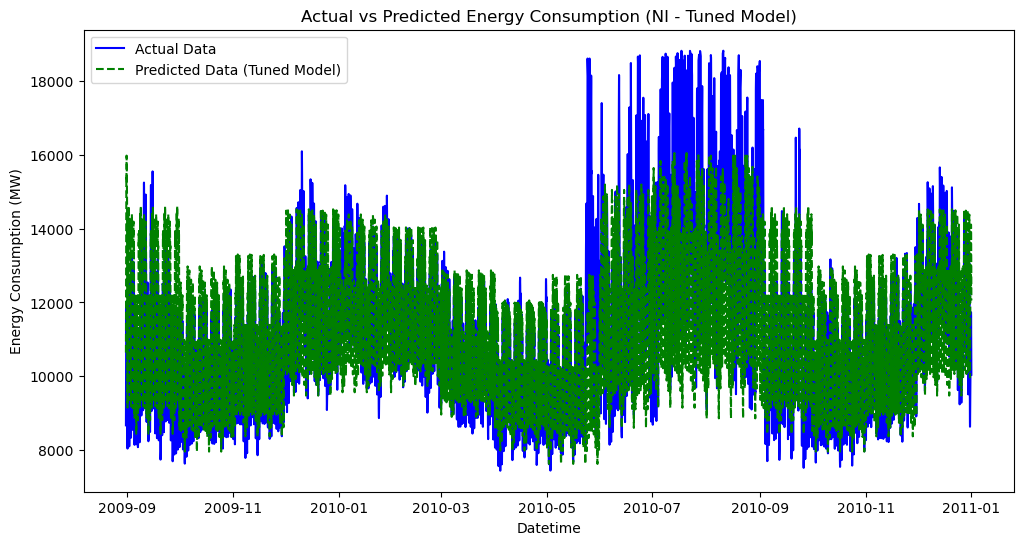

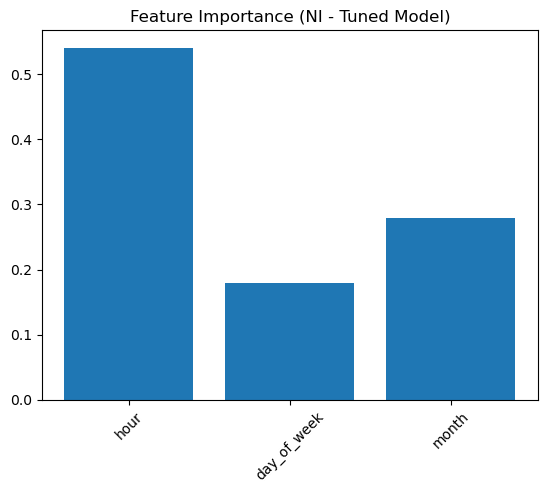

Best parameters for NI from GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Metrics for PJMW (Tuned Model):
  Root Mean Squared Error (RMSE): 605.75
  Normalized RMSE (nRMSE): 11.84%
  Mean Absolute Percentage Error (MAPE): 8.46%


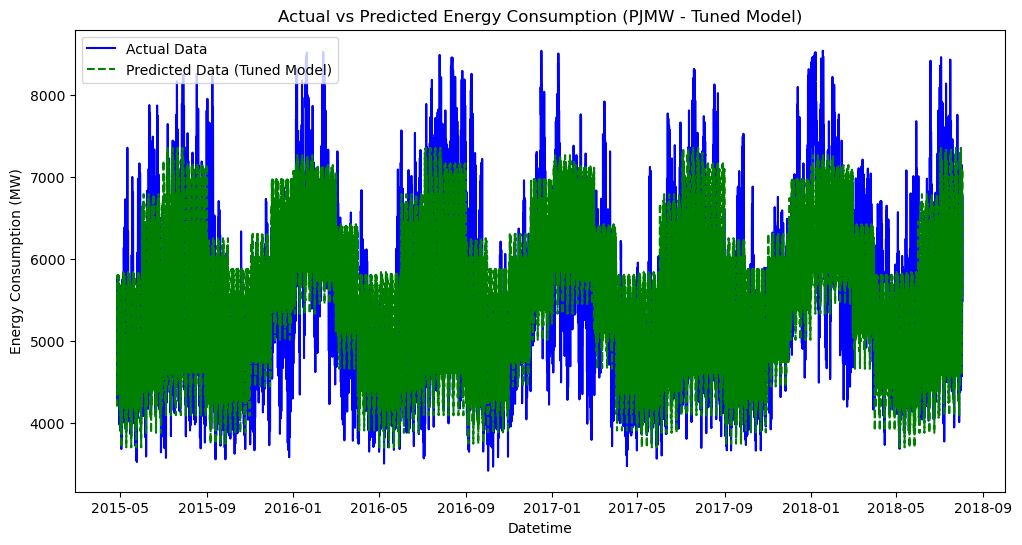

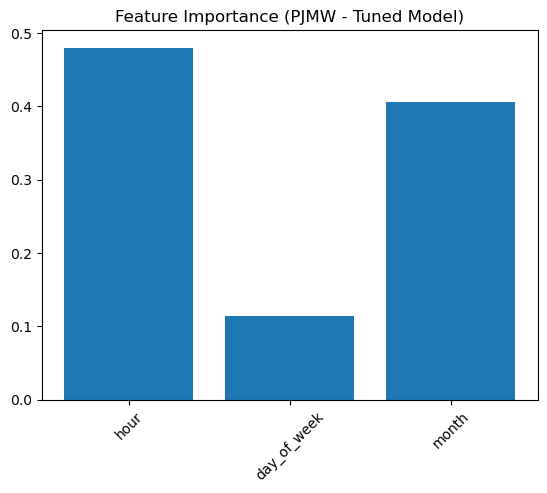

Best parameters for PJMW from GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

for utility, df in processed_data.items():
    target = f'{utility}_MW'
    features = ['hour', 'day_of_week', 'month'] 
    X = df[features]
    y = df[target]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) 

    # Initialize RandomForestRegressor and perform GridSearchCV
    rf_tuned = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf_tuned, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)

    # Get the best estimator from GridSearchCV
    best_rf = grid_search.best_estimator_

    # Predictions
    y_pred_tuned = best_rf.predict(X_test)

    # Evaluate the model using RMSE, nRMSE, and MAPE
    rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    range_y = y_test.max() - y_test.min()
    nrmse_tuned = rmse_tuned / range_y if range_y > 0 else np.nan
    mape_tuned = mean_absolute_percentage_error(y_test, y_pred_tuned)

    # Print metrics
    print(f"Metrics for {utility} (Tuned Model):")
    print(f"  Root Mean Squared Error (RMSE): {rmse_tuned:.2f}")
    print(f"  Normalized RMSE (nRMSE): {nrmse_tuned:.2%}")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape_tuned:.2%}")

    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Actual Data', color='blue')
    plt.plot(y_test.index, y_pred_tuned, label='Predicted Data (Tuned Model)', color='green', linestyle='--')
    plt.title(f'Actual vs Predicted Energy Consumption ({utility} - Tuned Model)')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

    # Feature importance visualization
    importance_tuned = best_rf.feature_importances_
    plt.bar(features, importance_tuned)
    plt.title(f'Feature Importance ({utility} - Tuned Model)')
    plt.xticks(rotation=45)
    plt.show()

    # Display the best parameters
    print(f"Best parameters for {utility} from GridSearchCV:")
    print(grid_search.best_params_)


# Analysis

## Data Used:

The graphs and analysis are based on hourly energy consumption data for various utility companies, covering a period that spans multiple years. This timeframe allows for capturing the seasonal and trend components inherent in energy consumption patterns over time, such as daily usage fluctuations, monthly changes, and seasonal energy consumption peaks

## Why Random Forest and Time-Based Features Are a Good Choice:

Random Forests are particularly effective for time-series forecasting because:
   
>• Handling non-linearity: Random Forest can model complex, non-linear relationships between input features and the target variable (energy consumption in this case), which is often seen in time-series data.

>• Feature importance: Random Forest inherently provides feature importance scores, allowing us to see which time-based features (hour of the day, day of the week, month of the year) are most influential in predicting energy consumption.

>• Robustness to overfitting: Due to its ensemble nature (combining multiple decision trees), Random Forest helps prevent overfitting, which is crucial in time-series forecasting where the data may have patterns that are difficult to capture with a single model.


## Ultimate Takeaway:

The root mean square error (RMSE) of most models indicates moderate success in predicting energy consumption. For most utilities, hyperparameter tuning resulted in slight or no improvement in RMSE values, but this doesn't necessarily imply that the model is ineffective. On certain datasets, RMSE values as low as 196 were achieved, while the highest observed RMSE was 1837. Even though the RMSE values aren't perfect, this model still holds value in its ability to provide insights into how different features affect energy consumption patterns.

## Feature Importance Insights:

Feature importance analysis revealed that, for most datasets, the hour of the day emerged as the most important feature, followed by month of the year in some cases. This suggests that energy consumption patterns vary primarily with the time of day, with some utilities also showing notable seasonal effects (as seen in the EKPC dataset, where the month of the year had a significant impact). This insight helps utilities better understand:

>• When energy consumption peaks during the day.

>• How seasonality affects energy demand throughout the year.